# GAN图像生成

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/application/zh_cn/generative/mindspore_gan.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/application/zh_cn/generative/mindspore_gan.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/tutorials/application/source_zh_cn/generative/gan.ipynb)


## 模型简介

生成式对抗网络(Generative Adversarial Networks，GAN)是一种生成式机器学习模型，是近年来复杂分布上无监督学习最具前景的方法之一。

最初，GAN由Ian J. Goodfellow于2014年发明，并在论文[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中首次进行了描述，其主要由两个不同的模型共同组成——生成器(Generative Model)和判别器(Discriminative Model)：

- 生成器的任务是生成看起来像训练图像的“假”图像；
- 判别器需要判断从生成器输出的图像是真实的训练图像还是虚假的图像。

GAN通过设计生成模型和判别模型这两个模块，使其互相博弈学习产生了相当好的输出。

GAN模型的核心在于提出了通过对抗过程来估计生成模型这一全新框架。在这个框架中，将会同时训练两个模型——捕捉数据分布的生成模型 $G$ 和估计样本是否来自训练数据的判别模型 $D$ 。

在训练过程中，生成器会不断尝试通过生成更好的假图像来骗过判别器，而判别器在这过程中也会逐步提升判别能力。这种博弈的平衡点是，当生成器生成的假图像和训练数据图像的分布完全一致时，判别器拥有50%的真假判断置信度。

用 $x$ 代表图像数据，用 $D(x)$表示判别器网络给出图像判定为真实图像的概率。在判别过程中，$D(x)$ 需要处理作为二进制文件的大小为 $1\times 28\times 28$ 的图像数据。当 $x$ 来自训练数据时，$D(x)$ 数值应该趋近于 $1$ ；而当 $x$ 来自生成器时，$D(x)$ 数值应该趋近于 $0$ 。因此 $D(x)$ 也可以被认为是传统的二分类器。

用 $z$ 代表标准正态分布中提取出的隐码(隐向量)，用 $G(z)$：表示将隐码(隐向量) $z$ 映射到数据空间的生成器函数。函数 $G(z)$ 的目标是将服从高斯分布的随机噪声 $z$ 通过生成网络变换为近似于真实分布 $p_{data}(x)$ 的数据分布，我们希望找到 $θ$ 使得 $p_{G}(x;\theta)$ 和 $p_{data}(x)$ 尽可能的接近，其中 $\theta$ 代表网络参数。

$D(G(z))$ 表示生成器 $G$ 生成的假图像被判定为真实图像的概率，如[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中所述，$D$ 和 $G$ 在进行一场博弈，$D$ 想要最大程度的正确分类真图像与假图像，也就是参数 $\log D(x)$；而 $G$ 试图欺骗 $D$ 来最小化假图像被识别到的概率，也就是参数 $\log(1−D(G(z)))$。因此GAN的损失函数为：

$$
\min\limits_{G}\max\limits_{D} V(D,G)=E_{x\sim p_{data}\;\,(x)}[\log D(x)]+E_{z\sim p_{z}\,(z)}[\log (1-D(G(z)))]
$$

从理论上讲，此博弈游戏的平衡点是$p_{G}(x;\theta) = p_{data}(x)$，此时判别器会随机猜测输入是真图像还是假图像。下面我们简要说明生成器和判别器的博弈过程：

1. 在训练刚开始的时候，生成器和判别器的质量都比较差，生成器会随机生成一个数据分布。
2. 判别器通过求取梯度和损失函数对网络进行优化，将靠近真实数据分布的数据判定为1，将靠近生成器生成出来数据分布的数据判定为0。
3. 生成器通过优化，生成出更加贴近真实数据分布的数据。
4. 生成器所生成的数据和真实数据达到相同的分布，此时判别器的输出为1/2。

![gan](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/gan_image.png)

在上图中，蓝色虚线表示判别器，黑色虚线表示真实数据分布，绿色实线表示生成器生成的虚假数据分布，$z$ 表示隐码，$x$ 表示生成的虚假图像 $G(z)$。该图片来源于[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)。详细的训练方法介绍见原论文。

## 数据集

### 数据集简介

[MNIST手写数字数据集](http://yann.lecun.com/exdb/mnist/)是NIST数据集的子集，共有70000张手写数字图片，包含60000张训练样本和10000张测试样本，数字图片为二进制文件，图片大小为28\*28，单通道。图片已经预先进行了尺寸归一化和中心化处理。

本案例将使用MNIST手写数字数据集来训练一个生成式对抗网络，使用该网络模拟生成手写数字图片。

### 数据集下载

使用`download`接口下载数据集，并将下载后的数据集自动解压到当前目录下。数据下载之前需要使用`pip install download`安装`download`包。

下载解压后的数据集目录结构如下：

```text
./MNIST_Data/
├─ train
│ ├─ train-images-idx3-ubyte
│ └─ train-labels-idx1-ubyte
└─ test
   ├─ t10k-images-idx3-ubyte
   └─ t10k-labels-idx1-ubyte
```

数据下载的代码如下：


In [1]:
# 数据下载
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip"
download(url, ".", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 24.7MB/s]
Extracting zip file...
Successfully downloaded / unzipped to .


'.'

### 数据加载

使用MindSpore自己的`MnistDatase`接口，读取和解析MNIST数据集的源文件构建数据集。然后对数据进行一些前处理。

In [2]:
import numpy as np
import mindspore.dataset as ds
import mindspore as ms

ms.set_context(max_device_memory="2GB", mode=ms.GRAPH_MODE, device_target="Ascend", jit_config={"jit_level":"O2"}, ascend_config={"precision_mode":"allow_mix_precision"})

batch_size = 128
latent_size = 100  # 隐码的长度

train_dataset = ds.MnistDataset(dataset_dir='./MNIST_Data/train')
test_dataset = ds.MnistDataset(dataset_dir='./MNIST_Data/test')

def data_load(dataset):
    dataset1 = ds.GeneratorDataset(dataset, ["image", "label"], shuffle=True, python_multiprocessing=False)
    # 数据增强
    mnist_ds = dataset1.map(
        operations=lambda x: (x.astype("float32"), np.random.normal(size=latent_size).astype("float32")),
        output_columns=["image", "latent_code"])
    mnist_ds = mnist_ds.project(["image", "latent_code"])

    # 批量操作
    mnist_ds = mnist_ds.batch(batch_size, True)

    return mnist_ds

mnist_ds = data_load(train_dataset)

iter_size = mnist_ds.get_dataset_size()
print('Iter size: %d' % iter_size)

[WARNING] ME(17688:281473359740944,MainProcess):2024-09-04-15:28:45.167.660 [mindspore/run_check/_check_version.py:357] MindSpore version 2.2.14 and Ascend AI software package (Ascend Data Center Solution)version 7.0 does not match, the version of software package expect one of ['7.1']. Please refer to the match info on: https://www.mindspore.cn/install
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
[WARNING] ME(17688:281473359740944,MainProcess):2024-09-04-15:28:47.455.524 [mindspore/run_check/_check_version.py:375] MindSpore version 2.2.14 and "te" wheel pack

Iter size: 468


### 数据集可视化

通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

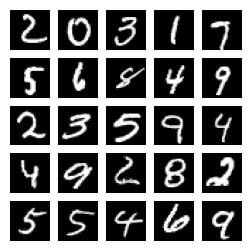

In [3]:
import matplotlib.pyplot as plt

data_iter = next(mnist_ds.create_dict_iterator(output_numpy=True))
figure = plt.figure(figsize=(3, 3))
cols, rows = 5, 5
for idx in range(1, cols * rows + 1):
    image = data_iter['image'][idx]
    figure.add_subplot(rows, cols, idx)
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### 隐码构造

为了跟踪生成器的学习进度，我们在训练的过程中的每轮迭代结束后，将一组固定的遵循高斯分布的隐码`test_noise`输入到生成器中，通过固定隐码所生成的图像效果来评估生成器的好坏。

In [4]:
import random
import numpy as np
from mindspore import Tensor, dtype

# 利用随机种子创建一批隐码
np.random.seed(2323)
test_noise = Tensor(np.random.normal(size=(25, 100)), dtype.float32)
random.shuffle(test_noise)

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])


## 模型构建

本案例实现中所搭建的 GAN 模型结构与原论文中提出的 GAN 结构大致相同，但由于所用数据集 MNIST 为单通道小尺寸图片，可识别参数少，便于训练，我们在判别器和生成器中采用全连接网络架构和 `ReLU` 激活函数即可达到令人满意的效果，且省略了原论文中用于减少参数的 `Dropout` 策略和可学习激活函数 `Maxout`。

### 生成器

生成器 `Generator` 的功能是将隐码映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的灰度图像(或 RGB 彩色图像)。在本案例演示中，该功能通过五层 `Dense` 全连接层来完成的，每层都与 `BatchNorm1d` 批归一化层和 `ReLU` 激活层配对，输出数据会经过 `Tanh` 函数，使其返回 [-1,1] 的数据范围内。注意实例化生成器之后需要修改参数的名称，不然静态图模式下会报错。

In [5]:
from mindspore import nn
import mindspore.ops as ops


img_size = 28  # 训练图像长（宽）

class Generator(nn.Cell):
    def __init__(self, latent_size, auto_prefix=True):
        super(Generator, self).__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 100] -> [N, 128]
        # 输入一个100维的0～1之间的高斯分布，然后通过第一层线性变换将其映射到256维
        self.model.append(nn.Dense(latent_size, 128))
        self.model.append(nn.ReLU())
        # [N, 128] -> [N, 256]
        self.model.append(nn.Dense(128, 256))
        self.model.append(nn.BatchNorm1d(256))
        self.model.append(nn.ReLU())
        # [N, 256] -> [N, 512]
        self.model.append(nn.Dense(256, 512))
        self.model.append(nn.BatchNorm1d(512))
        self.model.append(nn.ReLU())
        # [N, 512] -> [N, 1024]
        self.model.append(nn.Dense(512, 1024))
        self.model.append(nn.BatchNorm1d(1024))
        self.model.append(nn.ReLU())
        # [N, 1024] -> [N, 784]
        # 经过线性变换将其变成784维
        self.model.append(nn.Dense(1024, img_size * img_size))
        # 经过Tanh激活函数是希望生成的假的图片数据分布能够在-1～1之间
        self.model.append(nn.Tanh())

    def construct(self, x):
        img = self.model(x)
        return ops.reshape(img, (-1, 1, 28, 28))

net_g = Generator(latent_size)
net_g.update_parameters_name('generator')

### 判别器

如前所述，判别器 `Discriminator` 是一个二分类网络模型，输出判定该图像为真实图的概率。主要通过一系列的 `Dense` 层和 `LeakyReLU` 层对其进行处理，最后通过 `Sigmoid` 激活函数，使其返回 [0, 1] 的数据范围内，得到最终概率。注意实例化判别器之后需要修改参数的名称，不然静态图模式下会报错。

In [6]:
 # 判别器
class Discriminator(nn.Cell):
    def __init__(self, auto_prefix=True):
        super().__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 784] -> [N, 512]
        self.model.append(nn.Dense(img_size * img_size, 512))  # 输入特征数为784，输出为512
        self.model.append(nn.LeakyReLU())  # 默认斜率为0.2的非线性映射激活函数
        # [N, 512] -> [N, 256]
        self.model.append(nn.Dense(512, 256))  # 进行一个线性映射
        self.model.append(nn.LeakyReLU())
        # [N, 256] -> [N, 1]
        self.model.append(nn.Dense(256, 1))
        self.model.append(nn.Sigmoid())  # 二分类激活函数，将实数映射到[0,1]

    def construct(self, x):
        x_flat = ops.reshape(x, (-1, img_size * img_size))
        return self.model(x_flat)

net_d = Discriminator()
net_d.update_parameters_name('discriminator')

## 模型推理

下面我们通过加载生成器网络模型参数文件来生成图像，代码如下：


file_sizes: 100%|██████████████████████████| 6.06M/6.06M [00:00<00:00, 32.7MB/s]


[WARNING] ME(17688:281473359740944,MainProcess):2024-09-04-15:30:44.963.035 [mindspore/train/serialization.py:1469] For 'load_param_into_net', remove parameter prefix name: optim_g, continue to load.


Successfully downloaded file to ./Generator199.ckpt


[ERROR] CORE(17688,ffff9f9f0010,python):2024-09-04-15:30:45.207.436 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_17688/3799052259.py]
[ERROR] CORE(17688,ffff9f9f0010,python):2024-09-04-15:30:45.207.521 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_17688/3799052259.py]


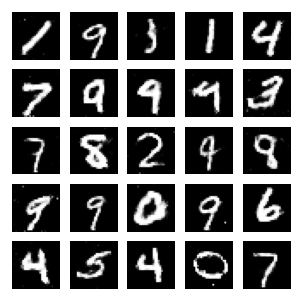

In [9]:
import mindspore as ms

# download ckpt
gan_url = "https://mindspore-courses.obs.cn-north-4.myhuaweicloud.com/orange-pi-online-infer/09-GAN/Generator199.ckpt"
path = "./Generator199.ckpt"
ckpt_path = download(gan_url, path, replace=True)
# test_ckpt = './Generator199.ckpt'

parameter = ms.load_checkpoint(ckpt_path)
ms.load_param_into_net(net_g, parameter)
# 模型生成结果
test_data = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
images = net_g(test_data).transpose(0, 2, 3, 1).asnumpy()
# 结果展示
fig = plt.figure(figsize=(3, 3), dpi=120)
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap="gray")
plt.show()